## **Baseline model**
**Implementing a baseline Logistic Regression model with TF-IDF.**



Including all Necessary Import statements

In [1]:
pip install wordcloud

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 511.1/511.1 kB 5.6 MB/s eta 0:00:00


In [2]:
!pip install imbalanced-learn

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 258.3/258.3 kB 3.7 MB/s eta 0:00:00


In [3]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import PorterStemmer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score, f1_score
from sklearn.preprocessing import LabelEncoder
from imblearn.over_sampling import SMOTE
from collections import Counter
from sklearn.metrics import confusion_matrix

# Download necessary NLTK data
nltk.download('punkt')
nltk.download('stopwords')

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


True

**Setting Custom NLTK Data Path**:
A custom path for NLTK data that allows the code to locate necessary datasets and resources in a specified directory on the user's computer.

Specify path - Locally

* `nltk_data_path`: Specifies the path to the folder where NLTK data is stored. `C:\Users\sam\AppData\Roaming\nltk_data`

* Adding custom path to NLTK:
`nltk.data.path.append(nltk_data_path)`: Adds the specified path to the list of directories NLTK searches for data.

* Verifying path:
`print(nltk.data.path)`: Prints the list of paths, confirming the addition of the custom path to NLTK’s search directories.

Google collab: `/content/TIL Dataset(Cleaned).csv`

In [4]:
import os
file_path = r"/content/TIL Dataset(Cleaned).csv"
if os.path.exists(file_path):
    print("File exists")
else:
    print("File does not exist")

File exists


Loading the dataset


In [5]:
# Loading the dataset
df = pd.read_csv(file_path)
print(df.info())
print(df.head())
print(df['target'].value_counts()) # Checking class distribution

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 871909 entries, 0 to 871908
Data columns (total 3 columns):
 #   Column      Non-Null Count   Dtype 
---  ------      --------------   ----- 
 0   text        871909 non-null  object
 1   target      871909 non-null  object
 2   Word Count  871909 non-null  int64 
dtypes: int64(1), object(2)
memory usage: 20.0+ MB
None
                                                text              target  \
0   python courses python courses, python exercis...  academic interests   
1  the learning point open digital education. a r...  academic interests   
2   equl offers enzyme assay kits, reagent mixtur...  academic interests   
3  tech news, latest technology, mobiles, laptops...  academic interests   
4  the best it certification materials in usa | k...  academic interests   

   Word Count  
0         125  
1         147  
2         353  
3         143  
4         364  
target
academic interests                           73134
books and literatu

Downloading all NLTK related Packages

In [6]:
nltk.download('all')

[nltk_data] Downloading collection 'all'
[nltk_data]    | 
[nltk_data]    | Downloading package abc to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/abc.zip.
[nltk_data]    | Downloading package alpino to /root/nltk_data...
[nltk_data]    |   Unzipping corpora/alpino.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping taggers/averaged_perceptron_tagger.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_eng to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_eng.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_ru to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |   Unzipping
[nltk_data]    |       taggers/averaged_perceptron_tagger_ru.zip.
[nltk_data]    | Downloading package averaged_perceptron_tagger_rus to
[nltk_data]    |     /root/nltk_data...
[nltk_data]    |  

True

### Data Preprocessing

Text Preprocessing Function for NLP

It defines a function, `preprocess_text`, which cleans and processes raw text data to prepare it for machine learning or NLP tasks. The function removes HTML tags, special characters, and stopwords and then tokenizes and normalizes the text.

In [7]:
import re
import nltk
from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize
from nltk.stem import WordNetLemmatizer
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences
from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import train_test_split
from tensorflow.keras.utils import to_categorical
from gensim.models import KeyedVectors

In [8]:
def preprocess_text(text, remove_stopwords=False):
    # Removing HTML tags
    text = re.sub('<[^>]*>', '', text)
    # Keeping alphanumeric characters and spaces
    text = re.sub('[^a-zA-Z0-9\s]', '', text)
    # Converting to lowercase
    text = text.lower()
    # Tokenize
    tokens = word_tokenize(text)
    # Removing stopwords
    if remove_stopwords:
        stop_words = set(stopwords.words('english'))
        tokens = [word for word in tokens if word not in stop_words]
    # Lemmatize tokens
    lemmatizer = WordNetLemmatizer()
    tokens = [lemmatizer.lemmatize(word) for word in tokens]
    return ' '.join(tokens)

# Applying preprocessing to the 'text' column
df['cleaned_text'] = df['text'].apply(lambda x: preprocess_text(x, remove_stopwords=True))

In [9]:
# Display a sample of cleaned text
print(df['cleaned_text'].head())

0    python course python course python exercise py...
1    learning point open digital education reposito...
2    equl offer enzyme assay kit reagent mixture en...
3    tech news latest technology mobile laptop ndtv...
4    best certification material usa killtest leadi...
Name: cleaned_text, dtype: object


### Exploratory Data Analysis (EDA)

* An exploratory analysis of the text dataset is performed, providing visual insights into class distribution, text length, and common words for each category.

* The goal is to understand data characteristics before further processing and model training.

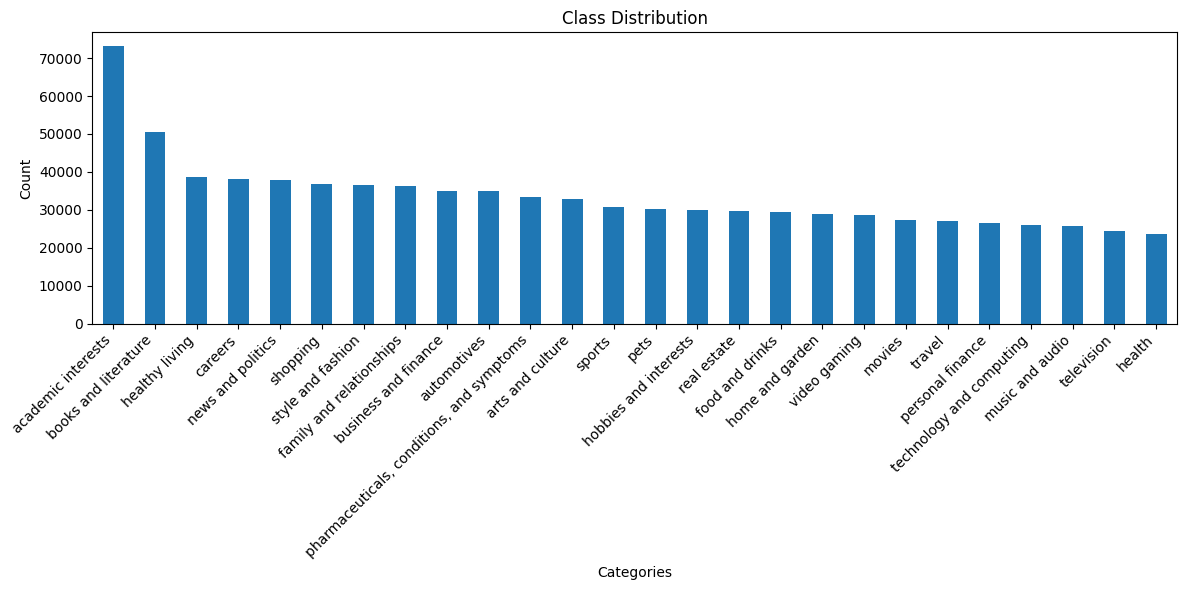

In [10]:
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud

# 1. Class distribution
plt.figure(figsize=(12, 6))
df['target'].value_counts().plot(kind='bar')
plt.title('Class Distribution')
plt.xlabel('Categories')
plt.ylabel('Count')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

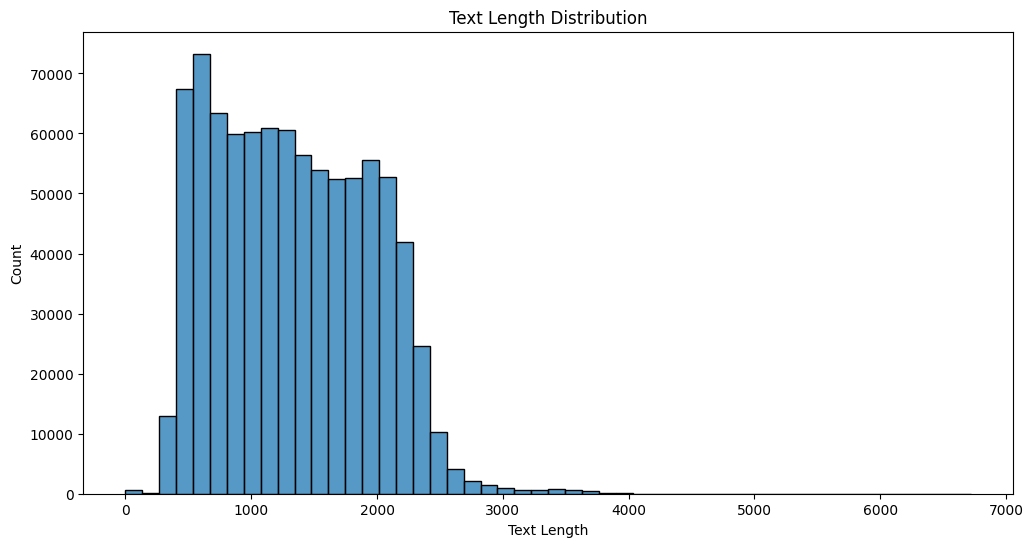

In [11]:
# 2. Text length distribution
df['text_length'] = df['cleaned_text'].apply(len)
plt.figure(figsize=(12, 6))
sns.histplot(df['text_length'], bins=50)
plt.title('Text Length Distribution')
plt.xlabel('Text Length')
plt.ylabel('Count')
plt.show()

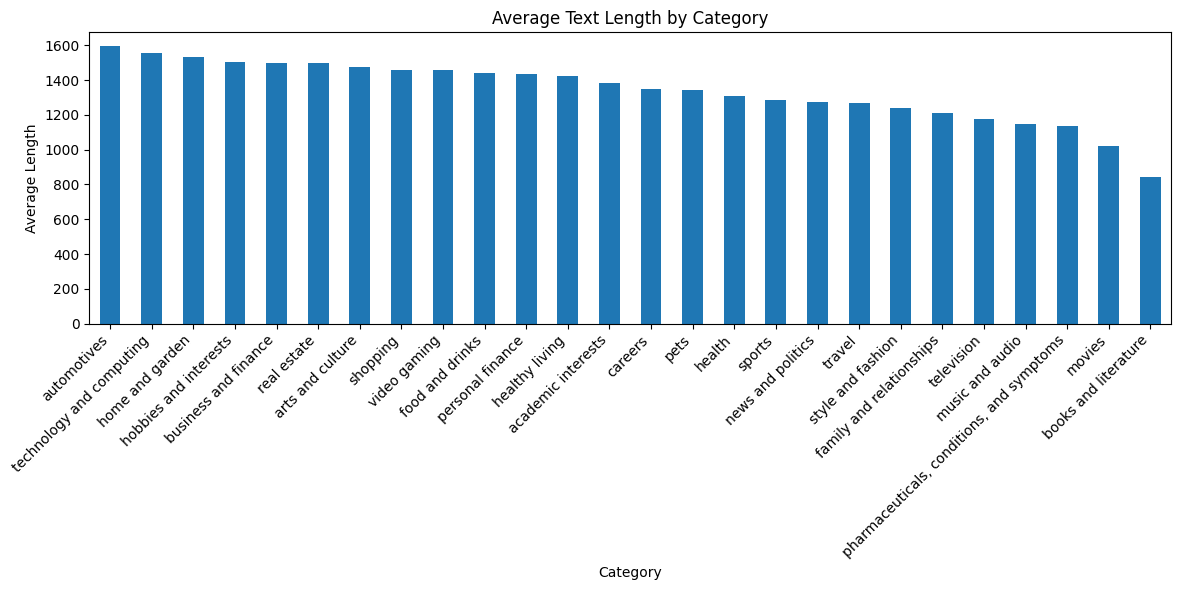

In [12]:
# 3. Average text length by category
avg_length = df.groupby('target')['text_length'].mean().sort_values(ascending=False)
plt.figure(figsize=(12, 6))
avg_length.plot(kind='bar')
plt.title('Average Text Length by Category')
plt.xlabel('Category')
plt.ylabel('Average Length')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

### Feature Extraction

**TF-IDF Vectorization for Text Data**

The preprocessed text data is converted into numerical form using TF-IDF (Term Frequency-Inverse Document Frequency) vectorization, preparing it for input into a machine learning model.

In [13]:
from sklearn.feature_extraction.text import TfidfVectorizer

tfidf = TfidfVectorizer(max_features=5000)
X = tfidf.fit_transform(df['cleaned_text'])
y = df['target']

### Handling Class Imbalance

**Addressing Class Imbalance with SMOTE**

* The SMOTE (Synthetic Minority Over-sampling Technique) algorithm to balance the class distribution in the dataset by generating synthetic samples for the minority classes
* This step helps improve model performance, especially in cases where certain categories are underrepresented.

In [14]:
from imblearn.over_sampling import SMOTE

smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X, y)

### Model Train Split

In [15]:
from sklearn.model_selection import train_test_split

# First, split off the test set (20% of the data)
X_temp, X_test, y_temp, y_test = train_test_split(X_resampled, y_resampled, test_size=0.2, random_state=42, stratify=y_resampled)

# Split 80% into training and validation
X_train, X_val, y_train, y_val = train_test_split(X_temp, y_temp, test_size=0.4375, random_state=42, stratify=y_temp)

# Verify the split sizes
print(f"Training set size: {X_train.shape[0]} ({X_train.shape[0]/X_resampled.shape[0]:.2%})")
print(f"Validation set size: {X_val.shape[0]} ({X_val.shape[0]/X_resampled.shape[0]:.2%})")
print(f"Test set size: {X_test.shape[0]} ({X_test.shape[0]/X_resampled.shape[0]:.2%})")

Training set size: 855667 (45.00%)
Validation set size: 665520 (35.00%)
Test set size: 380297 (20.00%)


* The total number of samples after resampling is 1,901,484 (855,667 + 665,520 + 380,297).

* This is larger than the original dataset size of 840,000, which suggests that the SMOTE (Synthetic Minority Over-sampling Technique) process has successfully balanced the classes by creating synthetic samples for minority classes.




### Training the baseline Model
Training and Evaluating a **Logistic Regression Model**

A logistic regression model is trained as baseline model on the resampled dataset and evaluates its performance on both a validation set and a test set.

In [16]:
# Train the model
lr_model = LogisticRegression(multi_class='ovr', max_iter=1000)
lr_model.fit(X_train, y_train)

# Evaluate on validation set
y_val_pred = lr_model.predict(X_val)
print("Validation Set Performance:")
print(classification_report(y_val, y_val_pred))

# Final evaluation on test set
y_test_pred = lr_model.predict(X_test)
print("Test Set Performance:")
print(classification_report(y_test, y_test_pred))

/usr/local/lib/python3.10/dist-packages/sklearn/linear_model/_logistic.py:1256: FutureWarning: 'multi_class' was deprecated in version 1.5 and will be removed in 1.7. Use OneVsRestClassifier(LogisticRegression(..)) instead. Leave it to its default value to avoid this warning.
  warnings.warn(


Validation Set Performance:
                                           precision    recall  f1-score   support

                       academic interests       0.73      0.78      0.75     25597
                         arts and culture       0.73      0.73      0.73     25597
                              automotives       0.92      0.93      0.93     25597
                     books and literature       0.84      0.87      0.85     25597
                     business and finance       0.66      0.66      0.66     25597
                                  careers       0.99      0.99      0.99     25597
                 family and relationships       0.67      0.73      0.70     25597
                          food and drinks       0.74      0.76      0.75     25597
                                   health       0.72      0.72      0.72     25597
                           healthy living       0.66      0.62      0.64     25597
                    hobbies and interests       0.84      

In [18]:
from sklearn.metrics import confusion_matrix
le = LabelEncoder()
y = le.fit_transform(df['target'])  # Encode target labels

### Evalulation

**Confusion Matrix**

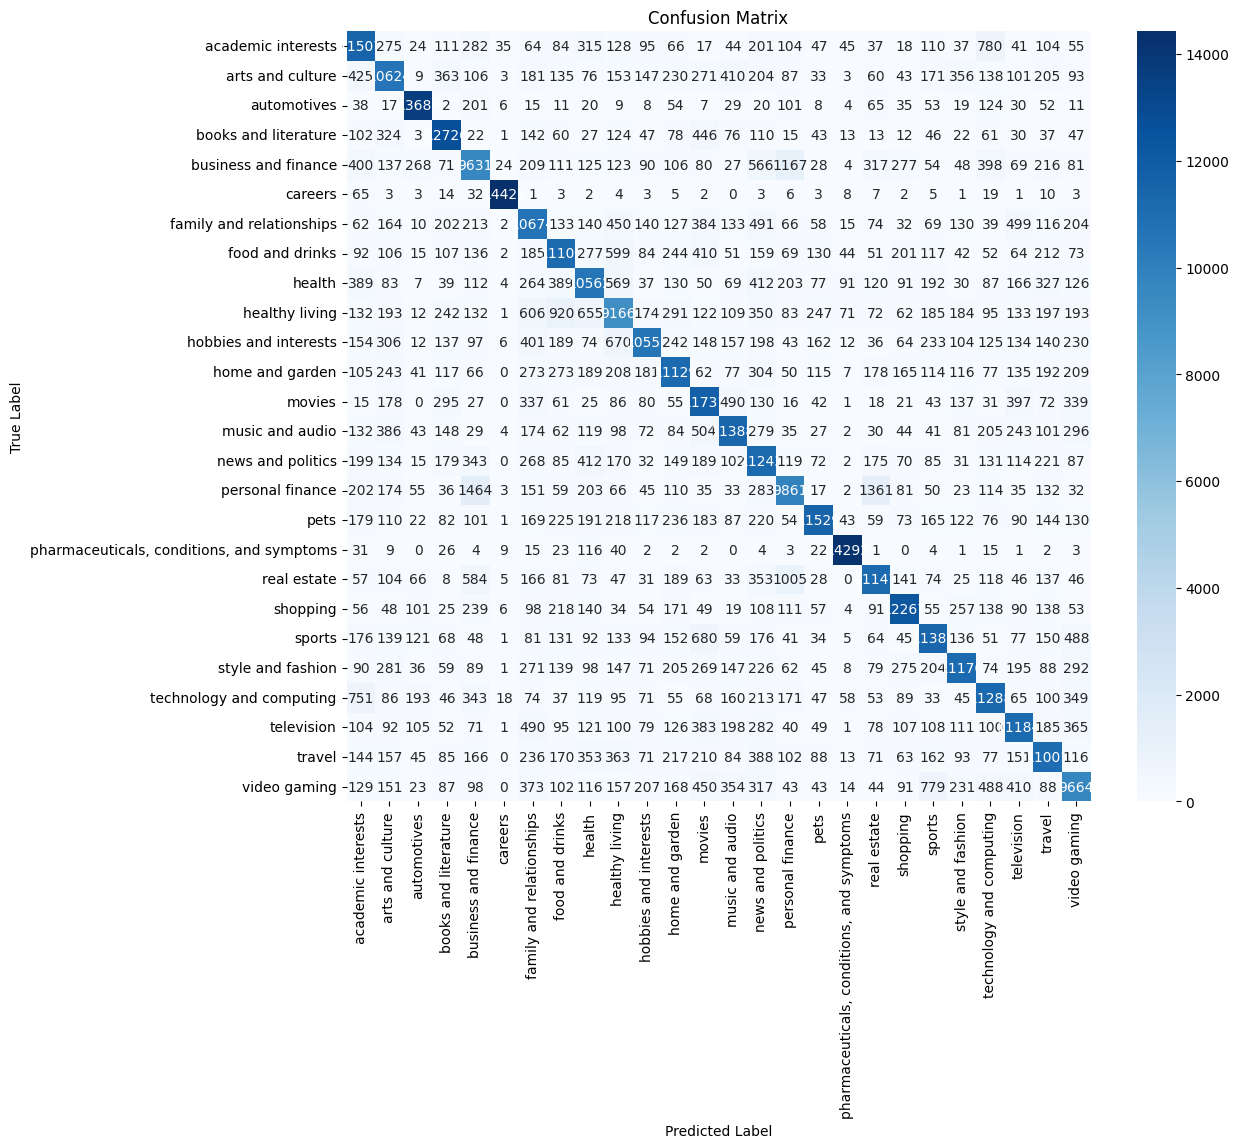

In [19]:
# Generated confusion matrix for test set predictions
cm = confusion_matrix(y_test, y_test_pred)
plt.figure(figsize=(12, 10))

# heatmap for the confusion matrix
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=le.classes_, yticklabels=le.classes_)
plt.title('Confusion Matrix')
plt.ylabel('True Label')
plt.xlabel('Predicted Label')
plt.show()

**Visualizing Classification Metrics by Class**

* The visualization of performance metrics (precision, recall, and F1-score) for each class in the validation set are over bar plots.
* The visualization provides a clearer view of how the model performs across different categories.

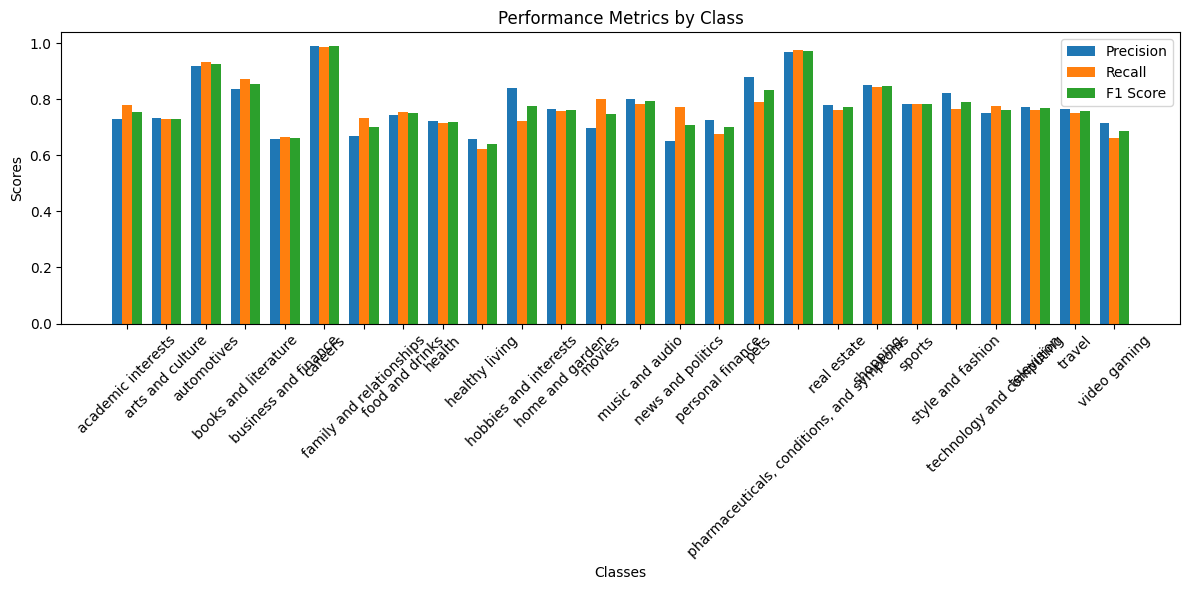

In [20]:
# Extract metrics from classification report
report = classification_report(y_val, y_val_pred, output_dict=True)
classes = list(report.keys())[:-3]  # Excluded 'accuracy', 'macro avg', 'weighted avg'
precision = [report[cls]['precision'] for cls in classes]
recall = [report[cls]['recall'] for cls in classes]
f1_score = [report[cls]['f1-score'] for cls in classes]

x = np.arange(len(classes))  # The label locations
width = 0.25
fig, ax = plt.subplots(figsize=(12, 6))
bars1 = ax.bar(x - width, precision, width, label='Precision')
bars2 = ax.bar(x, recall, width, label='Recall')
bars3 = ax.bar(x + width, f1_score, width, label='F1 Score')
ax.set_xlabel('Classes')
ax.set_ylabel('Scores')
ax.set_title('Performance Metrics by Class')
ax.set_xticks(x)
ax.set_xticklabels(classes)
ax.legend()

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()